In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import itertools
import random
import os
import csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [31]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # # Force TensorFlow to use single thread
    # # Multiple threads are a potential source of non-reproducible results.
    # session_conf = tf.compat.v1.ConfigProto(
    #     intra_op_parallelism_threads=1,
    #     inter_op_parallelism_threads=1
    # )

    # # Make sure that TensorFlow uses a deterministic operation wherever possible
    # tf.compat.v1.set_random_seed(seed)

    # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    # tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [32]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


In [34]:
len(df)

2956

In [35]:
# Only want closing price for each day 
TSLA = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
TSLA.head()

,Price
Date,
2010-06-29,4.778
2010-06-30,4.766
2010-07-01,4.392
2010-07-02,3.840
2010-07-06,3.222


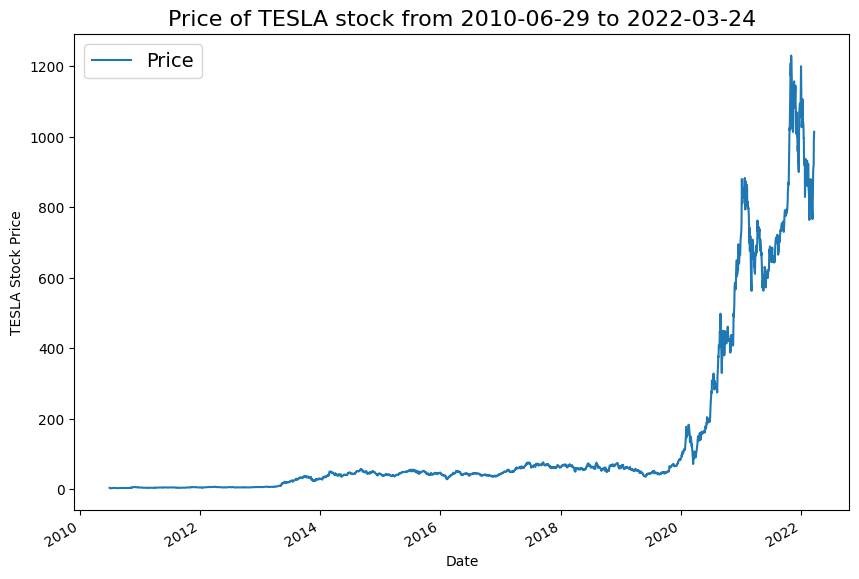

In [36]:
import matplotlib.pyplot as plt
TSLA.plot(figsize=(10, 7))
plt.ylabel("TESLA Stock Price")
plt.title("Price of TESLA stock from 2010-06-29 to 2022-03-24", fontsize=16)
plt.legend(fontsize=14);

In [37]:
import csv

# Open the CSV file
with open("/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv", "r") as f:
    # Create a CSV reader object
    reader = csv.reader(f)
    
    # Read the first row (header) of the CSV file
    header = next(reader)
    
    # Print the column names
    print(header)
    print(header[4])


['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Close


In [40]:
import csv
from datetime import datetime

timesteps = []
stock_price = []
with open("/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
    next(csv_reader) # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
        stock_price.append(float(line[4])) # get the closing price as float

# View first 10 of each
timesteps[:10], stock_price[:10]


([datetime.datetime(2010, 6, 29, 0, 0),
  datetime.datetime(2010, 6, 30, 0, 0),
  datetime.datetime(2010, 7, 1, 0, 0),
  datetime.datetime(2010, 7, 2, 0, 0),
  datetime.datetime(2010, 7, 6, 0, 0),
  datetime.datetime(2010, 7, 7, 0, 0),
  datetime.datetime(2010, 7, 8, 0, 0),
  datetime.datetime(2010, 7, 9, 0, 0),
  datetime.datetime(2010, 7, 12, 0, 0),
  datetime.datetime(2010, 7, 13, 0, 0)],
 [4.778, 4.766, 4.392, 3.84, 3.222, 3.16, 3.492, 3.48, 3.41, 3.628])

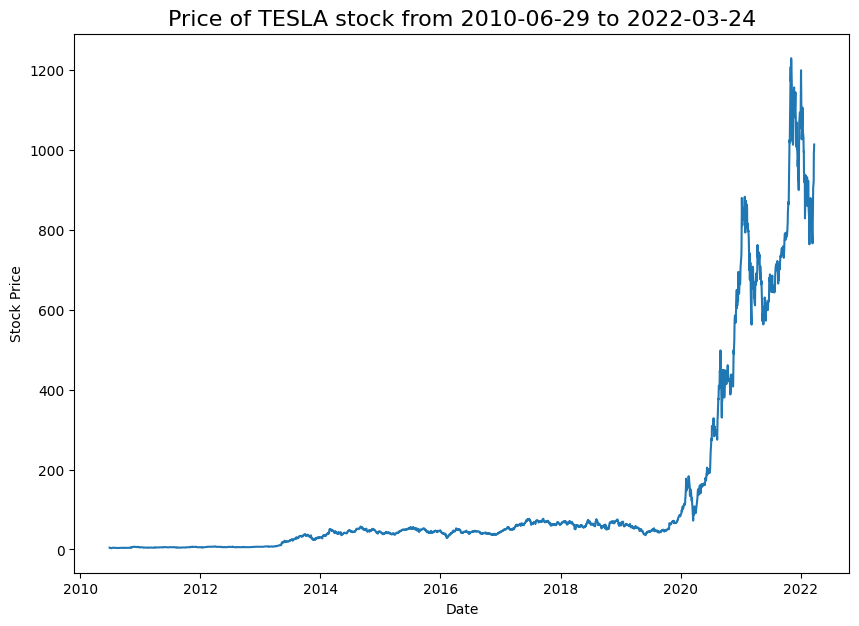

In [41]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, stock_price)
plt.title("Price of TESLA stock from 2010-06-29 to 2022-03-24", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Stock Price");

In [42]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(stock_price)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], stock_price[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], stock_price[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2364, 592, 2364, 592)

In [43]:
# Convert list to NumPy array
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

# Now you can use .shape
print(X_train_np.shape, y_train_np.shape, X_test_np.shape, y_test_np.shape)

(2364,) (2364,) (592,) (592,)


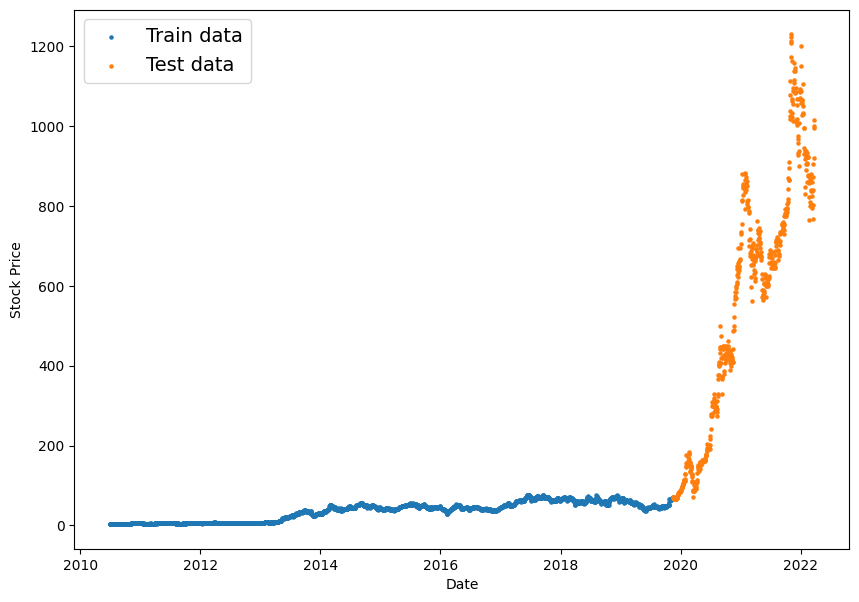

In [44]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend(fontsize=14)
plt.show();

In [45]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Stock Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

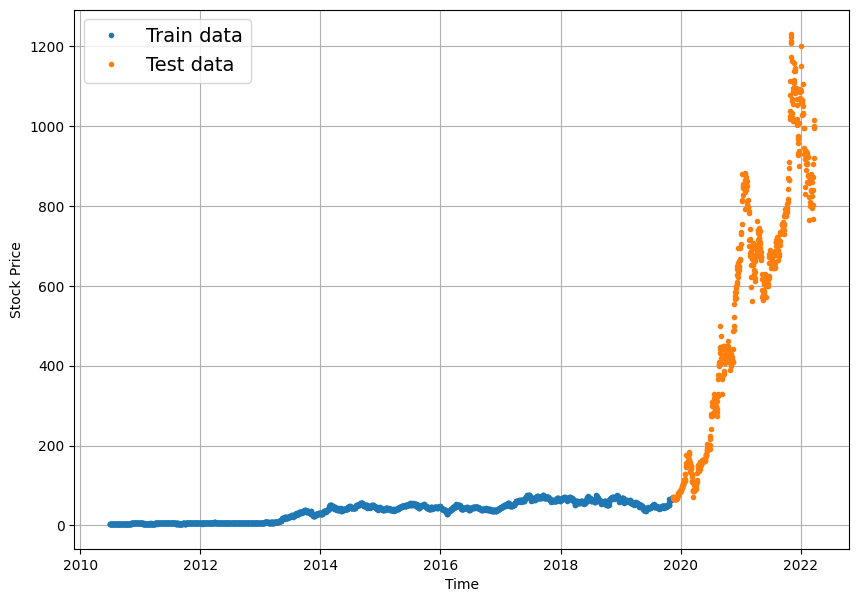

In [46]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

In [47]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [48]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [49]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, shuffle=True):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method
      shuffle(bool) - whether to shuffle the dataset

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


In [50]:
# Parameters
window_size = 7
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer_size)

In [51]:
# Generate the windowed dataset for the validation set, without shuffling
val_set = windowed_dataset(y_test, window_size, batch_size, shuffle_buffer_size, shuffle=False)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, Lambda
from tensorflow.keras.optimizers import Adam
!pip install keras-tuner
import keras_tuner as kt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.0 MB/s eta 0:00:0000:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 which is incompatible.
beatrix-jupyterlab 2023.46.184821 requires jupyter-server~=1.16, but you have jupyter-server 2.5.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you hav

In [ ]:
BATCH_SIZE=32

In [54]:
def build_model(hp):
    
    # Define all hyperparameters
    n_layers = hp.Choice('n_layers', [1, 2, 3])
    dropout_rate = hp.Choice('dropout_rate', [0.2, 0.3, 0.4, 0.5])
    n_units = hp.Choice('n_units', [50, 100, 200])
    n_filters = hp.Choice('n_filters', [32, 64, 128])
    kernel_size = hp.Choice('kernel_size', [2, 3, 5])
    
    # Model architecture
    model = Sequential()
    
    # Lambda layer to expand dimensions
    model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]))
    
    # Conv1D for feature extraction
    model.add(Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # Add LSTM layers 
    for i in range(n_layers):
        if i == 0:
            # First layer specifies return sequences if more than one LSTM layer
            model.add(Bidirectional(LSTM(n_units, return_sequences=(n_layers != 1), activation='relu')))
        else:
            # Middle layers return sequences, last layer doesn't
            model.add(Bidirectional(LSTM(n_units, return_sequences=(i != n_layers - 1), activation='relu')))
        
        # Add Dropout after each LSTM layer
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    # Compile the model
    model.compile(
        loss='mean_squared_error',
        optimizer = Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        metrics = ['mean_absolute_error']
    )
    
    # Return model
    return model


In [55]:
# Initialize Random Searcher
random_searcher = kt.RandomSearch(
    hypermodel=build_model, 
    objective='val_loss', 
    max_trials=20, 
    seed=42, 
    project_name="TSLA_Search"
)

# Start Searching
search = random_searcher.search(
    train_set,
    validation_data=val_set,
    epochs = 30,
    batch_size = BATCH_SIZE
)

Trial 20 Complete [00h 02m 05s]
val_loss: 2774.45068359375

Best val_loss So Far: 1502.77783203125
Total elapsed time: 00h 21m 14s


In [56]:
# Collect the best model LSTM Model Architecture obtained by Random Searcher
best_model = build_model(random_searcher.get_best_hyperparameters(num_trials=1)[0])

# Model Architecture
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 7, 1)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 128)            768       
                                                                 
 batch_normalization_1 (Batc  (None, 3, 128)           512       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 400)              526400    
 nal)                                                            
                                                      

In [57]:
# Compile Model
best_model.compile(
    loss='mean_squared_error',
    optimizer=Adam(best_model.optimizer.learning_rate),
    metrics=['mean_absolute_error']
)

# Model Training
best_model_history = best_model.fit(
    train_set,
    validation_data=val_set,
    epochs = 100,
    batch_size = BATCH_SIZE*2,
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True),
        ModelCheckpoint("BestModel.h5", save_best_only=True)
    ]
)

Epoch 1/100
74/74 [==============================] - 5s 19ms/step - loss: 68.4605 - mean_absolute_error: 5.9194 - val_loss: 47871.0625 - val_mean_absolute_error: 188.1741
Epoch 2/100
74/74 [==============================] - 1s 14ms/step - loss: 109.4612 - mean_absolute_error: 7.7726 - val_loss: 6362.0537 - val_mean_absolute_error: 65.1056
Epoch 3/100
74/74 [==============================] - 1s 13ms/step - loss: 124.7709 - mean_absolute_error: 8.0618 - val_loss: 2460.6697 - val_mean_absolute_error: 35.9092
Epoch 4/100
74/74 [==============================] - 1s 15ms/step - loss: 116.4710 - mean_absolute_error: 8.0407 - val_loss: 7155.2588 - val_mean_absolute_error: 65.1757
Epoch 5/100
74/74 [==============================] - 1s 13ms/step - loss: 127.6913 - mean_absolute_error: 8.2624 - val_loss: 36975.3047 - val_mean_absolute_error: 162.0237
Epoch 6/100
74/74 [==============================] - 1s 13ms/step - loss: 100.9906 - mean_absolute_error: 7.1834 - val_loss: 4512.8081 - val_mean_a

In [58]:
#  Load model 
best_model = tf.keras.models.load_model('BestModel.h5')
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 7, 1)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 128)            768       
                                                                 
 batch_normalization_1 (Batc  (None, 3, 128)           512       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 400)              526400    
 nal)                                                            
                                                      

In [59]:
# Evaluate the best USE model
best_test_loss, best_test_acc = best_model.evaluate(val_set)
print(f"Validation MSE after Tuning     : {best_test_loss} ")
print(f"Validation MAE after Tuning : {best_test_acc}  ")


19/19 [==============================] - 1s 6ms/step - loss: 1424.3326 - mean_absolute_error: 26.0768
Validation MSE after Tuning     : 1424.3326416015625 
Validation MAE after Tuning : 26.0767765045166  


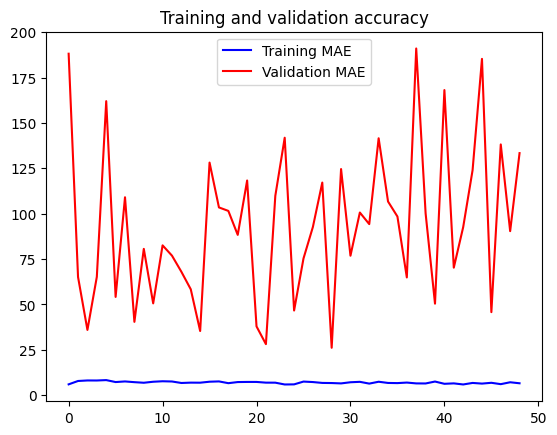

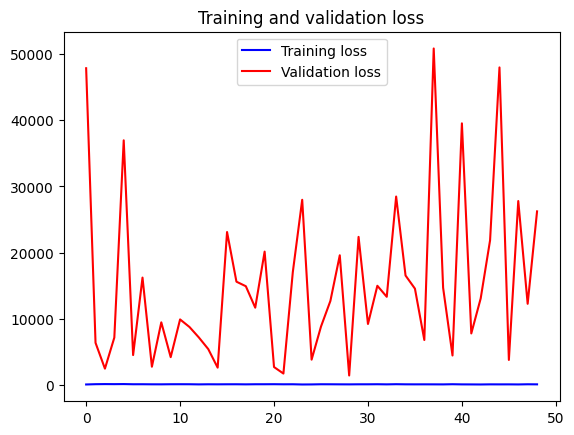

In [60]:
# Extract the history from the best USE model
accuracy = best_model_history.history['mean_absolute_error']
val_accuracy = best_model_history.history['val_mean_absolute_error']

loss = best_model_history.history['loss']
val_loss = best_model_history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training MAE')
plt.plot(epochs, val_accuracy, 'r', label='Validation MAE')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()


In [61]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [62]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [63]:
split_size

2364

19/19 [==============================] - 0s 7ms/step


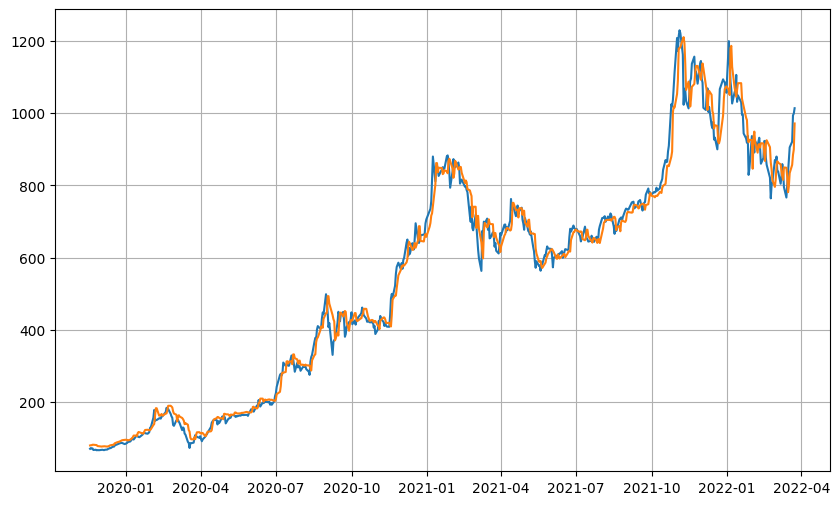

In [64]:
# Reduce the original series
forecast_series = stock_price[split_size-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(best_model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(X_test, (y_test, results))

**Multivariate**

In [65]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


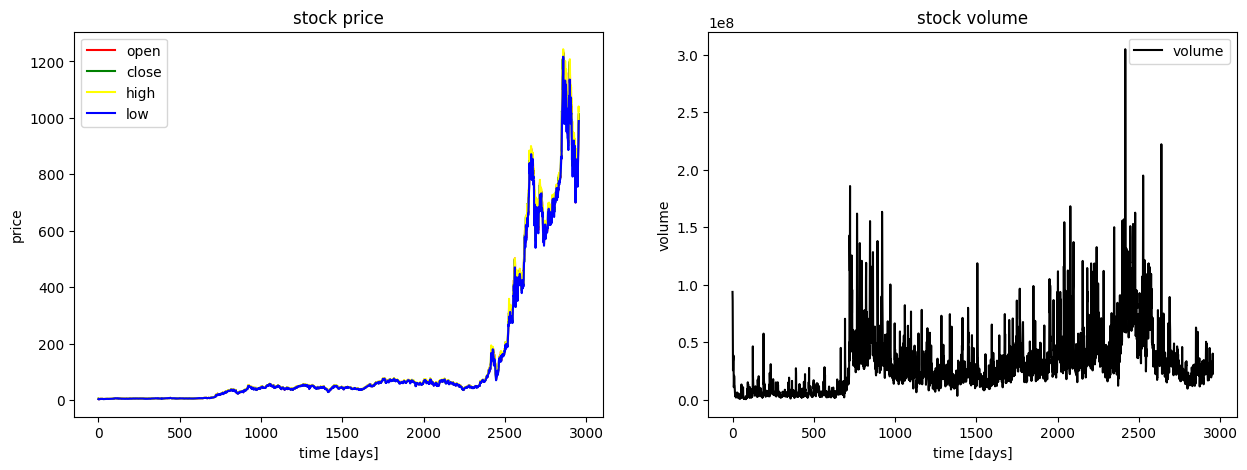

In [70]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Close.values, color='green', label='close')
plt.plot(df.High.values, color='yellow', label='high')
plt.plot(df.Low.values, color='blue', label='low')
# plt.plot(df["Adj Close"].values, color='black', label='adj close')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df.Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [71]:
# Scalling
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
data = df.copy()
data.drop(['Adj Close'], axis=1, inplace=True)
x = data[['Open', 'Low', 'High', 'Volume']].copy()
y = data['Close'].copy()

x[['Open', 'Low', 'High', 'Volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

#

In [72]:
x.shape, y.shape

((2956, 4), (2956, 1))

In [73]:
x, y

(                Open       Low      High    Volume
 Date                                              
 2010-06-29  0.000465  0.000422  0.001350  0.306605
 2010-06-30  0.001568  0.001371  0.002224  0.280640
 2010-07-01  0.001439  0.000871  0.001498  0.133184
 2010-07-02  0.001114  0.000614  0.001043  0.082560
 2010-07-06  0.000627  0.000140  0.000543  0.110956
 ...              ...       ...       ...       ...
 2022-03-18  0.707663  0.712019  0.729358  0.107911
 2022-03-21  0.740550  0.744721  0.757580  0.087914
 2022-03-22  0.752750  0.756797  0.801937  0.114097
 2022-03-23  0.793312  0.801813  0.836481  0.130328
 2022-03-24  0.817509  0.812027  0.823410  0.073362
 
 [2956 rows x 4 columns],
 array([[0.00131893],
        [0.00130915],
        [0.00100428],
        ...,
        [0.80767879],
        [0.81186057],
        [0.82393312]]))

In [74]:
#Splitting

def load_data(X, seq_len, train_size=0.9):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[train_split:, :-1] 
    y_test = data[train_split:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

window = 7
x['Close'] = y
X_train, y_train, X_test, y_test = load_data(x, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2653, 7, 5) (2653,) (295, 7, 5) (295,)


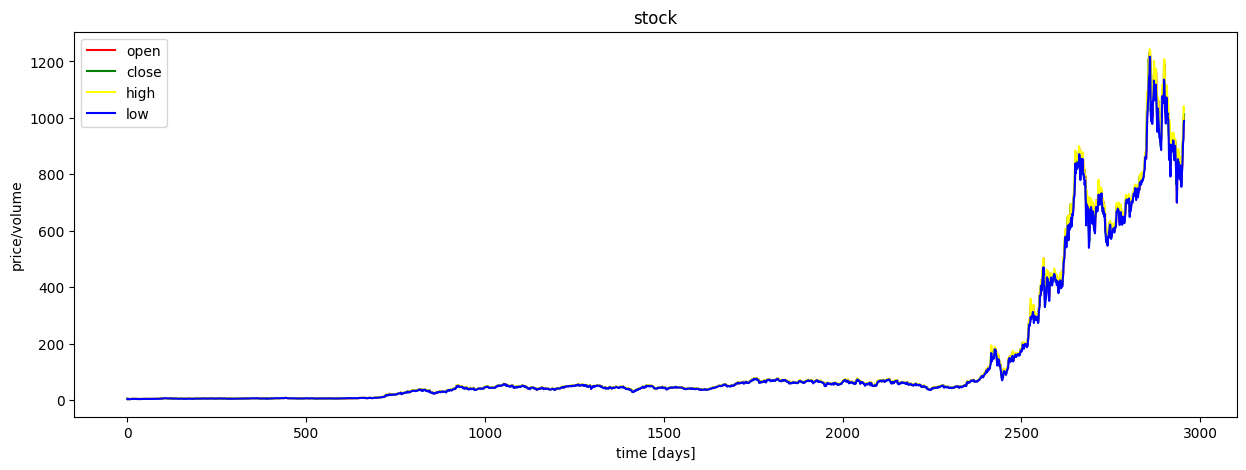

In [75]:
plt.figure(figsize=(15, 5));
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Close.values, color='green', label='close')
plt.plot(df.High.values, color='yellow', label='high')
plt.plot(df.Low.values, color='blue', label='low')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('price/volume')
plt.legend(loc='best')
plt.show()

**Model 1: LSTM**

In [77]:
X_train.shape[1], X_train.shape[2]

(7, 5)

In [78]:
import time

tf.random.set_seed(42) # set random seed for reproducibility

#LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.5))
# The output layer
model.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
LSTM=model.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)


Epoch 1/100
72/72 [==============================] - 10s 42ms/step - loss: 6.9373e-04 - val_loss: 0.0613
Epoch 2/100
72/72 [==============================] - 1s 17ms/step - loss: 9.7780e-05 - val_loss: 0.0172
Epoch 3/100
72/72 [==============================] - 1s 16ms/step - loss: 7.5360e-05 - val_loss: 0.0113
Epoch 4/100
72/72 [==============================] - 1s 17ms/step - loss: 6.3169e-05 - val_loss: 0.0123
Epoch 5/100
72/72 [==============================] - 1s 16ms/step - loss: 5.2427e-05 - val_loss: 0.0086
Epoch 6/100
72/72 [==============================] - 1s 16ms/step - loss: 6.4549e-05 - val_loss: 0.0166
Epoch 7/100
72/72 [==============================] - 1s 17ms/step - loss: 5.8507e-05 - val_loss: 0.0150
Epoch 8/100
72/72 [==============================] - 1s 17ms/step - loss: 5.3382e-05 - val_loss: 0.0081
Epoch 9/100
72/72 [==============================] - 1s 16ms/step - loss: 7.3027e-05 - val_loss: 0.0107
Epoch 10/100
72/72 [==============================] - 1s 16ms/s

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 50)             11200     
                                                                 
 dropout_4 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 7, 50)             20200     
                                                                 
 dropout_5 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_6 (LSTM)               (None, 7, 50)             20200     
                                                                 
 dropout_6 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

<AxesSubplot: >

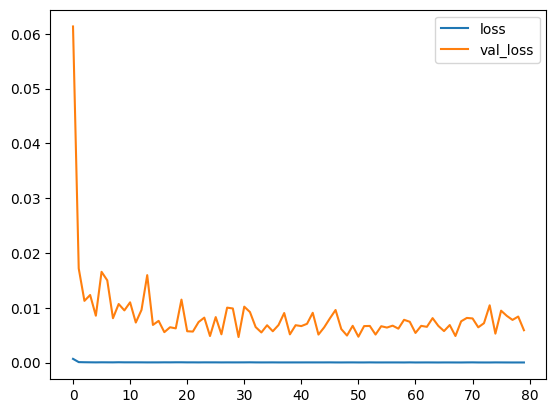

In [80]:
%matplotlib inline
losses = pd.DataFrame(LSTM.history)
losses.plot()

In [81]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

10/10 [==============================] - 0s 6ms/step


In [82]:
testPredict.shape

(295, 1)

In [83]:
plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(testPredict.shape[0], testPredict.shape[1])
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(testPredict.shape[0], testPredict.shape[1])
print(plot_actual.shape)
print(plot_predicted.shape)

(295, 1)
(295, 1)


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


In [85]:
plot_x = df.index.copy()


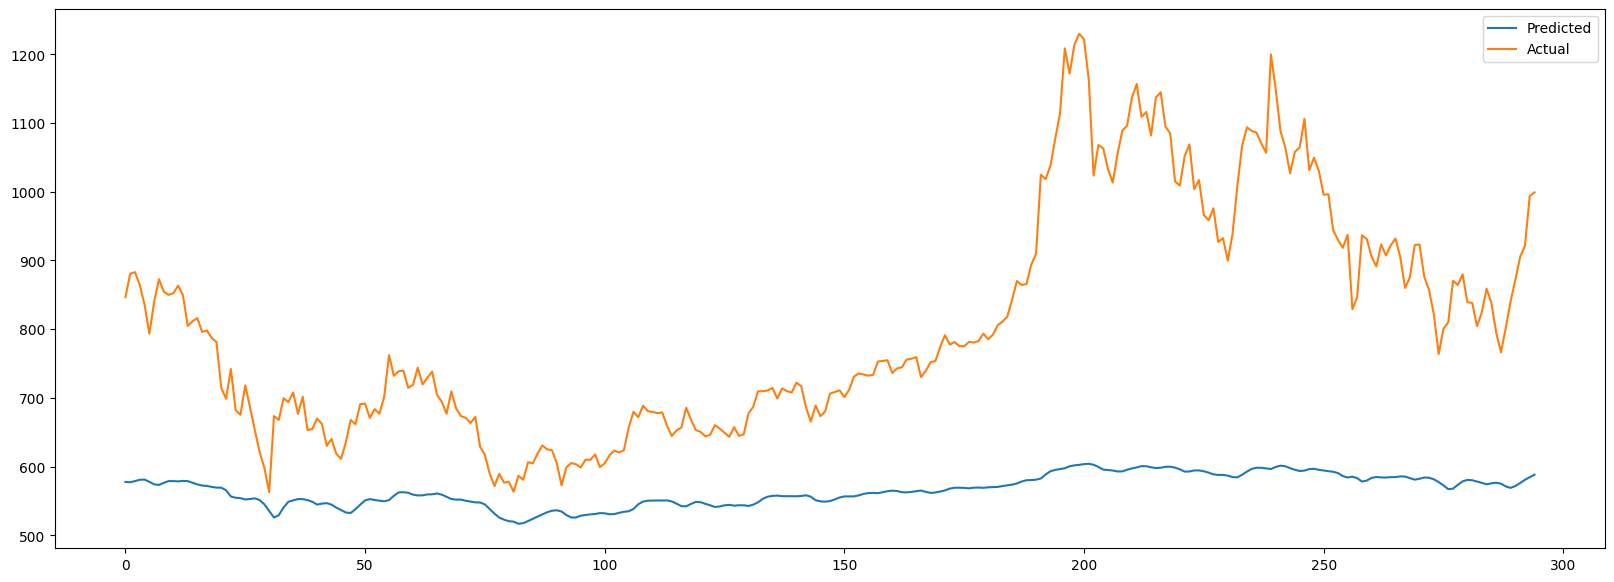

In [88]:
plt.figure(figsize=(20,7))
plot_x = plot_x[-294:]
plot_x = pd.to_datetime(plot_x)
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [90]:
from sklearn.metrics import mean_squared_error, r2_score

trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.59 RMSE
Test Score: 278.88 RMSE


In [93]:
stock_prices = df.Close.values.astype('float32')
stock_prices = stock_prices.reshape(len(stock_prices), 1)

In [94]:
trainPredictPlot = np.empty_like(stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[22:len(trainPredict)+22, :] = trainPredict

testPredictPlot = np.empty_like(stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(stock_prices) - testPredict.shape[0]):len(stock_prices), :] = testPredict

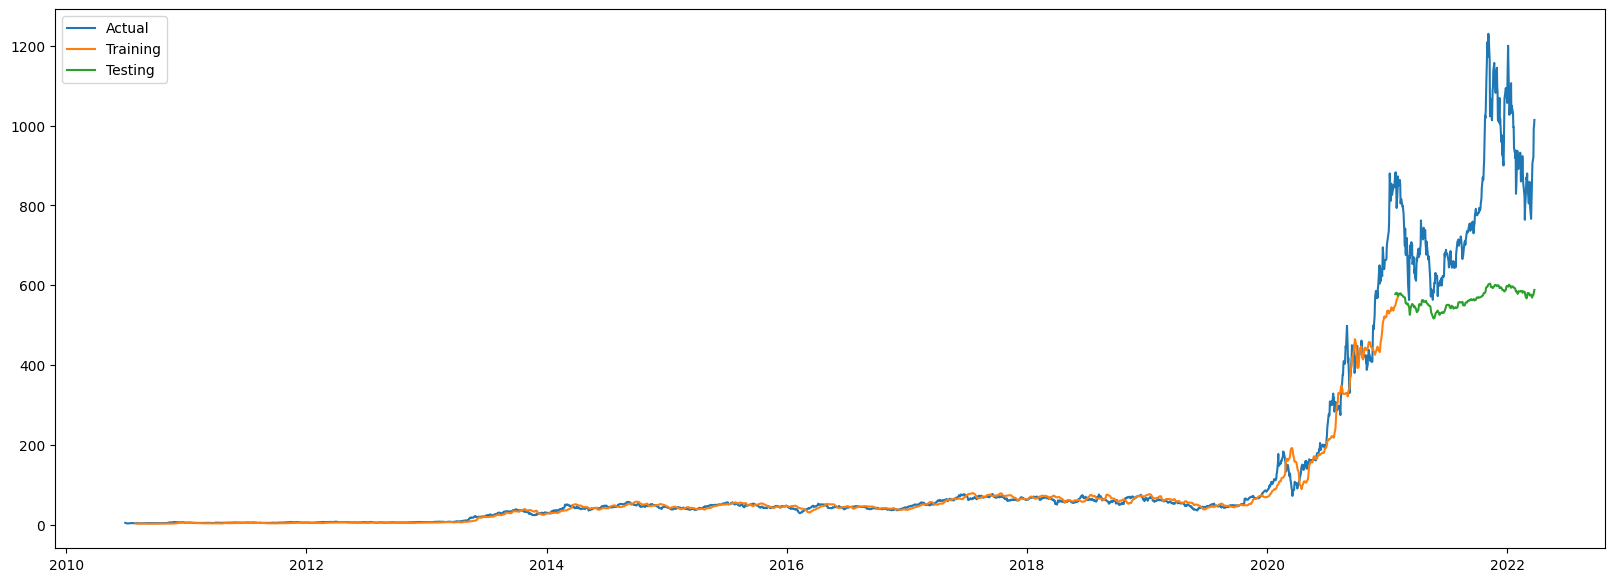

In [97]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(stock_prices, columns=["close"], index=data.index).close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=data.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=data.index).close, label='Testing')
plt.legend(loc='best')
plt.show()

**Hyperparameter Tuning**

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, Lambda
from tensorflow.keras.optimizers import Adam
!pip install keras-tuner
import keras_tuner as kt


In [99]:
BATCH_SIZE=32

In [100]:
X_train.shape[1], X_train.shape[2]


(7, 5)

In [101]:
def build_model(hp):
    
    # Define all hyperparameters
    n_layers = hp.Choice('n_layers', [1, 2, 3])
    dropout_rate = hp.Choice('dropout_rate', [0.2, 0.3, 0.4, 0.5])
    n_units = hp.Choice('n_units', [50, 100, 200])
    n_filters = hp.Choice('n_filters', [32, 64, 128])
    kernel_size = hp.Choice('kernel_size', [2, 3, 5])
    
    # Model architecture
    model = Sequential()
    
    # Conv1D for feature extraction
    model.add(Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # Add LSTM layers 
    for i in range(n_layers):
        if i == 0:
            # First layer specifies return sequences if more than one LSTM layer
            model.add(Bidirectional(LSTM(n_units, return_sequences=(n_layers != 1), activation='relu')))
        else:
            # Middle layers return sequences, last layer doesn't
            model.add(Bidirectional(LSTM(n_units, return_sequences=(i != n_layers - 1), activation='relu')))
        
        # Add Dropout after each LSTM layer
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
    model.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))
    
    # Compile the model
    model.compile(
        loss='mean_squared_error',
        optimizer = Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        metrics = ['mean_absolute_error']
    )
    
    # Return model
    return model


In [103]:
# Initialize Random Searcher
random_searcher = kt.RandomSearch(
    hypermodel=build_model, 
    objective='val_loss', 
    max_trials=20, 
    seed=42, 
    project_name="TSLASearch"
)

# Start Searching
search = random_searcher.search(
    X_train,y_train,
    validation_split=0.05,
    epochs = 30,
    batch_size = BATCH_SIZE
)

Trial 20 Complete [00h 01m 45s]
val_loss: 0.011496316641569138

Best val_loss So Far: 0.0010363301262259483
Total elapsed time: 00h 17m 20s


In [104]:
# Collect the best model LSTM Model Architecture obtained by Random Searcher
best_model = build_model(random_searcher.get_best_hyperparameters(num_trials=1)[0])

# Model Architecture
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 5, 128)            2048      
                                                                 
 batch_normalization_1 (Batc  (None, 5, 128)           512       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 128)           0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              183200    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                      

In [106]:
# Compile Model
best_model.compile(
    loss='mean_squared_error',
    optimizer=Adam(best_model.optimizer.learning_rate),
    metrics=['mean_absolute_error']
)

# Model Training
best_model_history = best_model.fit(
    X_train,y_train,
    validation_split=0.05,
    epochs = 100,
    batch_size = BATCH_SIZE*2,
    callbacks = [
        EarlyStopping(patience=30, restore_best_weights=True),
        ModelCheckpoint("BestModel.h5", save_best_only=True, verbose=1)
    ]
)

Epoch 1/100
35/40 [=========================>....] - ETA: 0s - loss: 3.0361e-05 - mean_absolute_error: 0.0036
Epoch 1: val_loss improved from inf to 0.00131, saving model to BestModel.h5
40/40 [==============================] - 5s 23ms/step - loss: 2.9655e-05 - mean_absolute_error: 0.0036 - val_loss: 0.0013 - val_mean_absolute_error: 0.0282
Epoch 2/100
36/40 [==========================>...] - ETA: 0s - loss: 3.0991e-05 - mean_absolute_error: 0.0035
Epoch 2: val_loss did not improve from 0.00131
40/40 [==============================] - 0s 11ms/step - loss: 3.0085e-05 - mean_absolute_error: 0.0034 - val_loss: 0.0026 - val_mean_absolute_error: 0.0404
Epoch 3/100
37/40 [==========================>...] - ETA: 0s - loss: 2.9402e-05 - mean_absolute_error: 0.0035
Epoch 3: val_loss did not improve from 0.00131
40/40 [==============================] - 0s 10ms/step - loss: 2.9186e-05 - mean_absolute_error: 0.0035 - val_loss: 0.0050 - val_mean_absolute_error: 0.0613
Epoch 4/100
35/40 [============

In [107]:
#  Load model 
best_model = tf.keras.models.load_model('BestModel.h5')
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 5, 128)            2048      
                                                                 
 batch_normalization_1 (Batc  (None, 5, 128)           512       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 128)           0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              183200    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                      

In [108]:
best_model.evaluate(X_test,y_test)

10/10 [==============================] - 0s 3ms/step - loss: 0.0058 - mean_absolute_error: 0.0524


[0.00584299024194479, 0.052356112748384476]

In [109]:
# Evaluate the best USE model
best_test_loss, best_test_acc = best_model.evaluate(X_test,y_test)
print(f"Validation MSE after Tuning     : {best_test_loss} ")
print(f"Validation MAE after Tuning : {best_test_acc}  ")


10/10 [==============================] - 0s 4ms/step - loss: 0.0058 - mean_absolute_error: 0.0524
Validation MSE after Tuning     : 0.00584299024194479 
Validation MAE after Tuning : 0.052356112748384476  


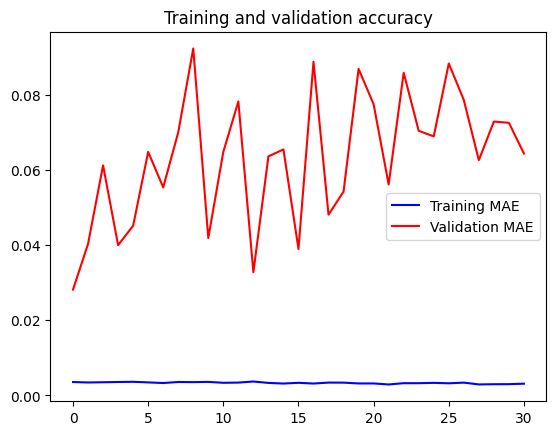

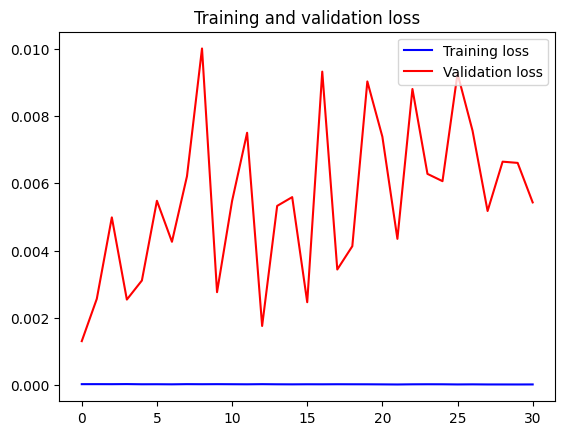

In [110]:
# Extract the history from the best USE model
accuracy = best_model_history.history['mean_absolute_error']
val_accuracy = best_model_history.history['val_mean_absolute_error']

loss = best_model_history.history['loss']
val_loss = best_model_history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training MAE')
plt.plot(epochs, val_accuracy, 'r', label='Validation MAE')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()


In [111]:
trainPredict = best_model.predict(X_train)
testPredict = best_model.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

10/10 [==============================] - 0s 3ms/step


In [112]:
plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(testPredict.shape[0], testPredict.shape[1])
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(testPredict.shape[0], testPredict.shape[1])
print(plot_actual.shape)
print(plot_predicted.shape)

(295, 1)
(295, 1)


In [113]:
plot_x = df.index.copy()


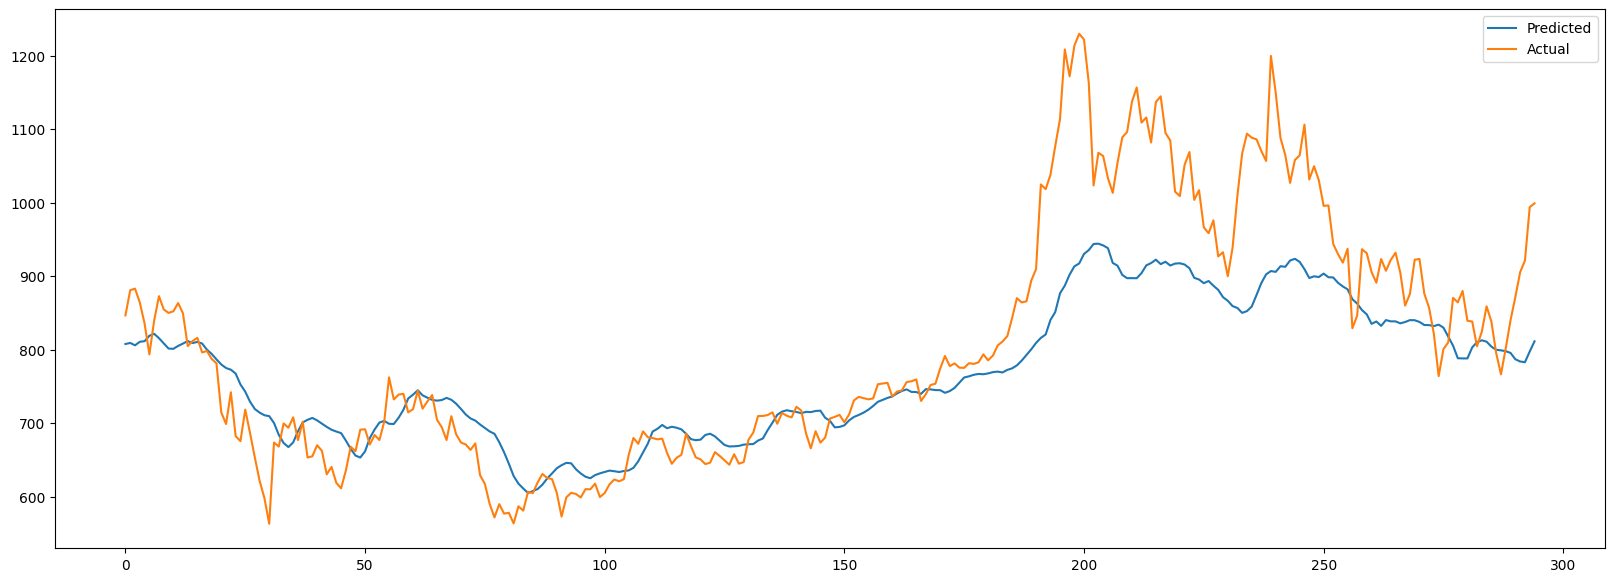

In [114]:
plt.figure(figsize=(20,7))
plot_x = plot_x[-294:]
plot_x = pd.to_datetime(plot_x)
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [115]:
from sklearn.metrics import mean_squared_error, r2_score

trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.43 RMSE
Test Score: 93.77 RMSE


In [117]:
stock_prices = df.Close.values.astype('float32')
stock_prices = stock_prices.reshape(len(stock_prices), 1)

In [118]:
trainPredictPlot = np.empty_like(stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[22:len(trainPredict)+22, :] = trainPredict

testPredictPlot = np.empty_like(stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(stock_prices) - testPredict.shape[0]):len(stock_prices), :] = testPredict

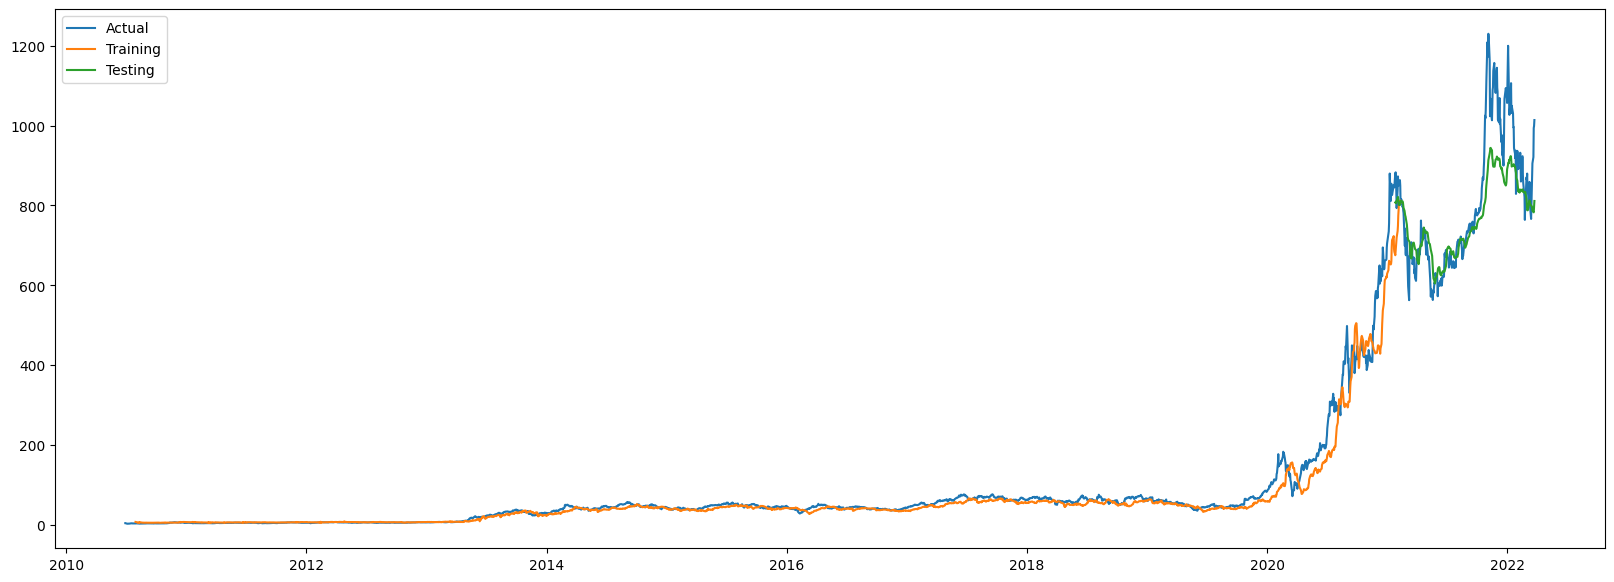

In [119]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(stock_prices, columns=["close"], index=data.index).close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=data.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=data.index).close, label='Testing')
plt.legend(loc='best')
plt.show()